### Co zrobione
  ### 'Data_pierwszej_rejestracji'
    - Naprawienie formatowania 'Data_pierwszej_rejestracji'
    - Rozdzielenie 'Data_pierwszej_rejestracji' na kolumny 'Miesiac_pierwszej_rejestracji' i 'Rok_pierwszej_rejestracji'
    - Zmiana nieprawindłowych lat z 'Rok_pierwszej_rejestracji' poprzez iterowanie po indeksach roku i zamianie ich na wartości o odpowiadającym indeksie z 'Rok_produkcji'
    - Usunięcie atrybutu 'Data_pierwszej_rejestracji' (Warto się zastanowić czy zostawić usunięte, czy może zrobić merge 'Miesiac_pierwszej_rejestracji' i 'Rok_pierwszej_rejestracji')
  ### 'Generacja_pojazdu'
    - Chyba nie trzeba czyścić, braki końcowego roku zdają się być schematyczne a nie wybiórcze.  Możliwe jednak że coś przegapiłem

  ### 'Cena' i 'Waluta'
    - Wartości ceny wyrażonej w EUR zostały przekonwertowane na PLN przy pomocy API NBP wedle średniego kursu walut dnia wystawienia pojazdu lub najbliższej dostępnej dacie wśród pozostałych wartości z EUR
    - Atrybut 'Waluta' usunięty skoro  wszystkie wartości wyrażone są w PLN

  ### 'Wyposazenie'
    - Wykonany One Hot Encoding wyposażenia
    - Usunięty atrybut 'Wyposazenie'

In [2]:
from enum import unique

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.f2py.auxfuncs import throw_error
from sklearn.preprocessing import TargetEncoder

In [3]:
df_car_sales_train_data = pd.read_csv('Data/sales_ads_train.csv',
    dtype={
        'Cena' : 'float',
        'Waluta': 'category',
        'Stan': 'category',
        'Marka_pojazdu': 'string',
        'Model_pojazdu': 'string',
        'Wersja_pojazdu': 'string',
        'Generacja_pojazdu': 'string',
        'Rok_produkcji': 'float64',
        'Przebieg_km': 'float',
        'Moc_KM': 'float',
        'Pojemnosc_cm3': 'float',
        'Rodzaj_paliwa': 'category',
        'Emisja_CO2': 'float',
        'Naped': 'category',
        'Skrzynia_biegow': 'category',
        'Typ_nadwozia': 'category',
        'Liczba_drzwi': 'float64',
        'Kolor': 'category',
        'Kraj_pochodzenia': 'category',
        'Pierwszy': 'category',
        'Lokalizacja_oferty': 'string',
        'Wyposazenie': 'string'

},
                           index_col="ID", parse_dates=['Data_pierwszej_rejestracji','Data_publikacji_oferty'], dayfirst=True)
df_car_sales_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135397 entries, 1 to 135397
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Cena                        135397 non-null  float64       
 1   Waluta                      132021 non-null  category      
 2   Stan                        132075 non-null  category      
 3   Marka_pojazdu               132046 non-null  string        
 4   Model_pojazdu               132088 non-null  string        
 5   Wersja_pojazdu              87336 non-null   string        
 6   Generacja_pojazdu           93737 non-null   string        
 7   Rok_produkcji               131990 non-null  float64       
 8   Przebieg_km                 131394 non-null  float64       
 9   Moc_KM                      131664 non-null  float64       
 10  Pojemnosc_cm3               130711 non-null  float64       
 11  Rodzaj_paliwa               131987 non-null 

In [4]:
df_car_sales_test_data = pd.read_csv('Data/sales_ads_test.csv',
    dtype={
        'Cena' : 'float',
        'Waluta': 'category',
        'Stan': 'category',
        'Marka_pojazdu': 'string',
        'Model_pojazdu': 'string',
        'Wersja_pojazdu': 'string',
        'Generacja_pojazdu': 'string',
        'Rok_produkcji': 'float64',
        'Przebieg_km': 'float',
        'Moc_KM': 'float',
        'Pojemnosc_cm3': 'float',
        'Rodzaj_paliwa': 'category',
        'Emisja_CO2': 'float',
        'Naped': 'category',
        'Skrzynia_biegow': 'category',
        'Typ_nadwozia': 'category',
        'Liczba_drzwi': 'float64',
        'Kolor': 'category',
        'Kraj_pochodzenia': 'category',
        'Pierwszy': 'category',
        'Lokalizacja_oferty': 'string',
        'Wyposazenie': 'string'
},
                           index_col="ID", parse_dates=['Data_pierwszej_rejestracji','Data_publikacji_oferty'], dayfirst=True)
df_car_sales_test_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 72907 entries, 1 to 72907
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Waluta                      72907 non-null  category      
 1   Stan                        72907 non-null  category      
 2   Marka_pojazdu               72907 non-null  string        
 3   Model_pojazdu               72907 non-null  string        
 4   Wersja_pojazdu              48394 non-null  string        
 5   Generacja_pojazdu           51734 non-null  string        
 6   Rok_produkcji               72907 non-null  float64       
 7   Przebieg_km                 72577 non-null  float64       
 8   Moc_KM                      72678 non-null  float64       
 9   Pojemnosc_cm3               72221 non-null  float64       
 10  Rodzaj_paliwa               72907 non-null  category      
 11  Emisja_CO2                  32946 non-null  float64       


# UWAGA!!
Łączenie danych testowych i treningowych tylko na czas czyszczenia stringów i formatowań!!!

In [5]:
df_car_sales_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135397 entries, 1 to 135397
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Cena                        135397 non-null  float64       
 1   Waluta                      132021 non-null  category      
 2   Stan                        132075 non-null  category      
 3   Marka_pojazdu               132046 non-null  string        
 4   Model_pojazdu               132088 non-null  string        
 5   Wersja_pojazdu              87336 non-null   string        
 6   Generacja_pojazdu           93737 non-null   string        
 7   Rok_produkcji               131990 non-null  float64       
 8   Przebieg_km                 131394 non-null  float64       
 9   Moc_KM                      131664 non-null  float64       
 10  Pojemnosc_cm3               130711 non-null  float64       
 11  Rodzaj_paliwa               131987 non-null 

In [6]:
df_car_sales_train_data["Wersja_pojazdu"].value_counts()

Wersja_pojazdu
2.0 TDI                                    596
1.6                                        540
Standard                                   418
1.2                                        392
2.0 TDCi Titanium                          390
                                          ... 
BlueHDi FAP 150 Stop&Start                   1
330i GPF xDrive Sport Line Shadow sport      1
2.4 Executive Navi                           1
1.6 Multijet Beats Edition S&S               1
1.9 TDI Sport Limited                        1
Name: count, Length: 16014, dtype: Int64

In [7]:
df_car_sales_test_data['Cena'] = pd.Series()
# df_car_sales = pd.concat([df_car_sales_train_data, df_car_sales_test_data], ignore_index = True)
df_car_sales = df_car_sales_train_data
# df_car_sales = df_car_sales_test_data
df_car_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135397 entries, 1 to 135397
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Cena                        135397 non-null  float64       
 1   Waluta                      132021 non-null  category      
 2   Stan                        132075 non-null  category      
 3   Marka_pojazdu               132046 non-null  string        
 4   Model_pojazdu               132088 non-null  string        
 5   Wersja_pojazdu              87336 non-null   string        
 6   Generacja_pojazdu           93737 non-null   string        
 7   Rok_produkcji               131990 non-null  float64       
 8   Przebieg_km                 131394 non-null  float64       
 9   Moc_KM                      131664 non-null  float64       
 10  Pojemnosc_cm3               130711 non-null  float64       
 11  Rodzaj_paliwa               131987 non-null 

In [8]:
df_car_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135397 entries, 1 to 135397
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Cena                        135397 non-null  float64       
 1   Waluta                      132021 non-null  category      
 2   Stan                        132075 non-null  category      
 3   Marka_pojazdu               132046 non-null  string        
 4   Model_pojazdu               132088 non-null  string        
 5   Wersja_pojazdu              87336 non-null   string        
 6   Generacja_pojazdu           93737 non-null   string        
 7   Rok_produkcji               131990 non-null  float64       
 8   Przebieg_km                 131394 non-null  float64       
 9   Moc_KM                      131664 non-null  float64       
 10  Pojemnosc_cm3               130711 non-null  float64       
 11  Rodzaj_paliwa               131987 non-null 

## Pierwszy właściciel

In [9]:
df_car_sales_test_data.loc[:, "Pierwszy_wlasciciel"].replace({"Yes": 1, "No": 0}, inplace=True)
df_car_sales_train_data.loc[:, "Pierwszy_wlasciciel"].replace({"Yes": 1, "No": 0}, inplace=True)

C:\Users\vipcy\AppData\Local\Temp\ipykernel_16728\2946300725.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_car_sales_test_data.loc[:, "Pierwszy_wlasciciel"].replace({"Yes": 1, "No": 0}, inplace=True)
C:\Users\vipcy\AppData\Local\Temp\ipykernel_16728\2946300725.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_d

### Czyszczenie i konwersja 'Data_pierwszej_rejestracji' do typu 'datetetime64'

In [10]:
df_car_sales['Data_pierwszej_rejestracji']

ID
1                NaN
2         16/06/2010
3                NaN
4         27/11/2007
5         20/05/2013
             ...    
135393    22/08/2018
135394           NaN
135395           NaN
135396           NaN
135397    31/01/2019
Name: Data_pierwszej_rejestracji, Length: 135397, dtype: object

Zakładając brak pomyłek:

 - najstarsze auto zostało wyprodukowane w 1923, lecz dane testowe zawierają w sobie nawet takie z 1915
 - dane pochodzą z 2021

In [11]:
df_car_sales['Rok_produkcji'].describe()

count    131990.000000
mean       2012.089901
std           7.003557
min        1923.000000
25%        2008.000000
50%        2013.000000
75%        2017.000000
max        2021.000000
Name: Rok_produkcji, dtype: float64

'Data_pierwszej_rejestracji' zawiera w sobie zarówno błędne formatowanie jak i rok rejestracji

In [12]:
df_car_sales['Data_pierwszej_rejestracji'] = df_car_sales['Data_pierwszej_rejestracji'].str.replace('//', '/')

In [13]:
# Dzielenie daty rejestracji na kolumny dnia, miesiąca i roku
first_registration_expanded_data = df_car_sales['Data_pierwszej_rejestracji'].str.split('/', expand=True).rename(columns={0: 'Dzien_pierwszej_rejestracji', 1: 'Miesiac_pierwszej_rejestracji', 2: 'Rok_pierwszej_rejestracji'})

In [14]:
# Łączenie datych z kolumną roku produkci pojazdu dla dalszej analizy
df_car_sales_with_expanded_registration_dates = pd.concat([df_car_sales['Rok_produkcji'], first_registration_expanded_data], axis=1)
df_car_sales_with_expanded_registration_dates

,Rok_produkcji,Dzien_pierwszej_rejestracji,Miesiac_pierwszej_rejestracji,Rok_pierwszej_rejestracji
ID,,,,
1,2005.0,NaN,NaN,NaN
2,2010.0,16,06,2010
3,2015.0,NaN,NaN,NaN
4,2007.0,27,11,2007
5,2013.0,20,05,2013
...,...,...,...,...
135393,2018.0,22,08,2018
135394,2021.0,NaN,NaN,NaN
135395,NaN,NaN,NaN,NaN


==============================

=========================

In [15]:
df_car_sales_with_expanded_registration_dates.loc[
    df_car_sales_with_expanded_registration_dates['Rok_pierwszej_rejestracji'].astype(float) < 1940
][['Rok_produkcji', 'Rok_pierwszej_rejestracji']]

# Zastąpienie pierwszych 2 cyfr roku cyframi z roku produkcji zdaje się że rozwiąże większość konfliktów

,Rok_produkcji,Rok_pierwszej_rejestracji
ID,,
1727,2006.0,0012
1890,2016.0,0017
2265,1998.0,0098
2744,1998.0,0098
3999,2000.0,0200
...,...,...
130368,2009.0,0209
131035,2006.0,0021
132905,2006.0,0019


In [16]:
# Dodać do listy zakupów
df_car_sales.iloc[32583]

Cena                                              1300000.0
Waluta                                                  PLN
Stan                                                   Used
Marka_pojazdu                                   Rolls-Royce
Model_pojazdu                                       Phantom
Wersja_pojazdu                                         <NA>
Generacja_pojazdu                                      <NA>
Rok_produkcji                                        1936.0
Przebieg_km                                         40355.0
Moc_KM                                                  NaN
Pojemnosc_cm3                                        3499.0
Rodzaj_paliwa                                      Gasoline
Emisja_CO2                                              NaN
Naped                                           Rear wheels
Skrzynia_biegow                                      Manual
Typ_nadwozia                                      city_cars
Liczba_drzwi                            

In [17]:
# Usuwanie ujemnych wartości z roku
df_car_sales_with_expanded_registration_dates['Rok_pierwszej_rejestracji'] = (df_car_sales_with_expanded_registration_dates['Rok_pierwszej_rejestracji'].
                                                                              str.replace('-', ''))

In [18]:
# Wyświetlanie danych gdzie rok pierwszej rejestracji jest wcześniejszy niż rok produkcji
df_car_sales_with_expanded_registration_dates.loc[
    df_car_sales_with_expanded_registration_dates['Rok_pierwszej_rejestracji'].astype(float) < df_car_sales_with_expanded_registration_dates['Rok_produkcji'].astype(float)
][['Rok_produkcji', 'Rok_pierwszej_rejestracji']]

,Rok_produkcji,Rok_pierwszej_rejestracji
ID,,
822,1998.0,1997
1089,2011.0,2010
1424,2010.0,2009
1727,2006.0,0012
1890,2016.0,0017
...,...,...
132594,2007.0,2006
132905,2006.0,0019
133581,2011.0,2010


In [19]:
# Sprawdzanie zcy Rok pierwszej rejestracji zawsze zawiera cyfry
mask = df_car_sales_with_expanded_registration_dates.loc[df_car_sales_with_expanded_registration_dates['Rok_pierwszej_rejestracji'].str.contains('[\\d]') == False].index
df_car_sales_with_expanded_registration_dates.loc[mask]['Rok_pierwszej_rejestracji']


Series([], Name: Rok_pierwszej_rejestracji, dtype: object)

In [20]:
df_car_sales_with_expanded_registration_dates.loc[df_car_sales_with_expanded_registration_dates['Rok_pierwszej_rejestracji'].str.contains('[0-9]{4}') == False]

,Rok_produkcji,Dzien_pierwszej_rejestracji,Miesiac_pierwszej_rejestracji,Rok_pierwszej_rejestracji
ID,,,,


In [21]:
test_data = df_car_sales_with_expanded_registration_dates

In [22]:
test_data.loc[(test_data['Rok_pierwszej_rejestracji'].notnull() & test_data['Rok_produkcji'].notnull()) & ((test_data['Rok_pierwszej_rejestracji'].astype(float) < test_data['Rok_produkcji'].astype(float)) | (test_data['Rok_pierwszej_rejestracji'].astype(float) > 2021))]

,Rok_produkcji,Dzien_pierwszej_rejestracji,Miesiac_pierwszej_rejestracji,Rok_pierwszej_rejestracji
ID,,,,
822,1998.0,28,05,1997
1089,2011.0,10,10,2010
1424,2010.0,12,12,2009
1727,2006.0,20,06,0012
1890,2016.0,10,08,0017
...,...,...,...,...
132594,2007.0,28,12,2006
132905,2006.0,07,06,0019
133581,2011.0,20,06,2010


In [23]:
test_data.loc[(test_data['Rok_pierwszej_rejestracji'].notnull() & test_data['Rok_produkcji'].notnull()) & ((test_data['Rok_pierwszej_rejestracji'].astype(float) < test_data['Rok_produkcji'].astype(float)) | (test_data['Rok_pierwszej_rejestracji'].astype(float) > 2021))]

,Rok_produkcji,Dzien_pierwszej_rejestracji,Miesiac_pierwszej_rejestracji,Rok_pierwszej_rejestracji
ID,,,,
822,1998.0,28,05,1997
1089,2011.0,10,10,2010
1424,2010.0,12,12,2009
1727,2006.0,20,06,0012
1890,2016.0,10,08,0017
...,...,...,...,...
132594,2007.0,28,12,2006
132905,2006.0,07,06,0019
133581,2011.0,20,06,2010


In [24]:
test_data.iloc[821]

Rok_produkcji                    1998.0
Dzien_pierwszej_rejestracji          28
Miesiac_pierwszej_rejestracji        05
Rok_pierwszej_rejestracji          1997
Name: 822, dtype: object

In [25]:
# Iterowanie po indeksach Rok_pierwszej_rejestracji i zastępowanie niewłaśiwyh wartości
for i in range(4):
    # Warunek
    mask = (
        df_car_sales_with_expanded_registration_dates['Rok_pierwszej_rejestracji'].notnull()
        & df_car_sales_with_expanded_registration_dates['Rok_produkcji'].notnull()
        & (
            (df_car_sales_with_expanded_registration_dates['Rok_pierwszej_rejestracji'].astype(float) < test_data['Rok_produkcji'])
            | (df_car_sales_with_expanded_registration_dates['Rok_pierwszej_rejestracji'].astype(float) > 2021)
        )
    )

    # Sprawdzenie, czy są wiersze spełniające warunek
    if not df_car_sales_with_expanded_registration_dates[mask].empty:
        # Pobranie indeksów pasujących wierszy
        matching_indices = df_car_sales_with_expanded_registration_dates[mask].index

        # Iteracja przez pasujące wiersze
        for idx in matching_indices:
            # Pobranie roku produkcji i konwersja na string
            production_year = str(int(df_car_sales_with_expanded_registration_dates.loc[idx, 'Rok_produkcji']))
            # Pobranie pierwszej cyfry roku produkcji
            production_year_digit = production_year[i] if i < len(production_year) else ''

            # Pobranie roku rejestracji
            registration_year = test_data.loc[idx, 'Rok_pierwszej_rejestracji']
            # Podział roku rejestracji na głowę i ogon
            registration_year_head = registration_year[:i]
            registration_year_tail = registration_year[i + 1:]

            # Utworzenie nowej wartości roku rejestracji
            new_registration_year = registration_year_head + production_year_digit + registration_year_tail

            # Aktualizacja wartości w DataFrame
            test_data.at[idx, 'Rok_pierwszej_rejestracji'] = new_registration_year

# Sprawdzanie czy dalej występują niepoprawne wartości
test_data.loc[(test_data['Rok_pierwszej_rejestracji'].notnull() & test_data['Rok_produkcji'].notnull()) & ((test_data['Rok_pierwszej_rejestracji'].astype(float) < test_data['Rok_produkcji'].astype(float)) | (test_data['Rok_pierwszej_rejestracji'].astype(float) > 2021))]

,Rok_produkcji,Dzien_pierwszej_rejestracji,Miesiac_pierwszej_rejestracji,Rok_pierwszej_rejestracji
ID,,,,


In [26]:
df_car_sales.loc[df_car_sales["Rok_produkcji"] == 2021]

,Cena,Waluta,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Generacja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,...,Skrzynia_biegow,Typ_nadwozia,Liczba_drzwi,Kolor,Kraj_pochodzenia,Pierwszy_wlasciciel,Data_pierwszej_rejestracji,Data_publikacji_oferty,Lokalizacja_oferty,Wyposazenie
ID,,,,,,,,,,,,,,,,,,,,,
11,138899.0,NaN,New,Volkswagen,Golf,<NA>,VIII (2020-),2021.0,1.0,150.0,...,Automatic,station_wagon,5.0,silver,Poland,NaN,NaN,2021-05-01,"ul. Radzymińska 78 - 03-752 Warszawa, Praga-Pó...","['ABS', 'Rear parking sensors', 'Immobilizer',..."
15,119900.0,PLN,New,Hyundai,Tucson,1.6 T-GDi Executive 2WD,II (2015-),2021.0,5.0,150.0,...,Manual,SUV,5.0,other,Poland,NaN,NaN,2021-04-30,<NA>,"['ABS', 'Electrically adjustable mirrors', 'Pa..."
19,58400.0,PLN,New,Dacia,Duster,<NA>,<NA>,2021.0,1.0,100.0,...,Manual,SUV,5.0,white,Poland,NaN,NaN,2021-05-04,"ul. Stalowa 16 - 41-506 Chorzów, Śląskie (Polska)","['ABS', 'Electric front windows', 'USB socket'..."
23,159237.0,PLN,New,Volvo,XC 40,T3 Momentum Pro,<NA>,2021.0,3.0,163.0,...,Automatic,SUV,5.0,golden,Poland,NaN,NaN,2021-05-01,"Marszałkowska 89 - 00-693 Warszawa, Śródmieści...","['ABS', 'Electrically adjustable mirrors', 'Pa..."
33,93105.0,PLN,New,Renault,Master,dCi 135 L3H2 VA,IV (2010-),2021.0,5.0,135.0,...,Manual,minivan,4.0,white,NaN,NaN,NaN,2021-05-02,"Warszawska 41 - 07-410 Ostrołęka, Mazowieckie ...","['ABS', 'Electrically adjustable mirrors', 'AS..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135325,136550.0,NaN,New,Volkswagen,Touran,<NA>,III (2015-),2021.0,5.0,150.0,...,Automatic,minivan,5.0,gray,Poland,NaN,NaN,2021-04-30,"Brzezińska 47 - 44-203 Rybnik, Śląskie (Polska)","['ABS', 'Lane assistant', 'CD', 'Front parking..."
135331,677900.0,PLN,New,Audi,RS Q8,<NA>,<NA>,2021.0,3000.0,600.0,...,Automatic,SUV,5.0,black,Poland,NaN,NaN,2021-05-02,"Radzymińska 267 - 03-643 Warszawa, Targówek (P...",[]
135365,85490.0,PLN,New,Kia,Ceed,<NA>,<NA>,2021.0,5.0,160.0,...,Manual,compact,5.0,blue,Poland,NaN,NaN,2021-05-04,"Lubelska 40 - 10-408 Olsztyn, Warmińsko-mazurs...","['ABS', 'Central locking', 'Electric front win..."


In [27]:
# Uzupełnij brakujące wartości w kolumnie "Rok_pierwszej_rejestracji" na podstawie kolumny "Rok_produkcji"
df_car_sales.loc[df_car_sales["Rok_pierwszej_rejestracji"].isnull(), "Rok_pierwszej_rejestracji"] = df_car_sales.loc[df_car_sales["Rok_pierwszej_rejestracji"].isnull(), "Rok_produkcji"].apply(lambda x: x + 2)

# Ogranicz wartości w kolumnie "Rok_pierwszej_rejestracji" do maksymalnie 2021
df_car_sales.loc[df_car_sales["Rok_pierwszej_rejestracji"] > 2021, "Rok_pierwszej_rejestracji"] = 2021

# Wyświetl kolumnę "Rok_pierwszej_rejestracji"
df_car_sales["Rok_pierwszej_rejestracji"]

KeyError: 'Rok_pierwszej_rejestracji'

## Merge oczyszczony rok i miesiac pierwszej rejestracji z danymi z df_car_sales

In [592]:
df_car_sales['Rok_pierwszej_rejestracji'] = df_car_sales_with_expanded_registration_dates['Rok_pierwszej_rejestracji']
df_car_sales['Miesiac_pierwszej_rejestracji']= df_car_sales_with_expanded_registration_dates['Miesiac_pierwszej_rejestracji']
df_car_sales.drop(columns=['Data_pierwszej_rejestracji'], inplace=True)
df_car_sales

,Waluta,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Generacja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,Pojemnosc_cm3,...,Liczba_drzwi,Kolor,Kraj_pochodzenia,Pierwszy_wlasciciel,Data_publikacji_oferty,Lokalizacja_oferty,Wyposazenie,Cena,Rok_pierwszej_rejestracji,Miesiac_pierwszej_rejestracji
ID,,,,,,,,,,,,,,,,,,,,,
1,PLN,New,Mercedes-Benz,GLC,200 d 4-Matic,<NA>,2021.0,1.0,163.0,1950.0,...,5.0,black,Poland,Yes,2021-04-30,"Władysława IV 43 - 81-395 Gdynia, Śródmieście ...","['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN
2,PLN,Used,Ford,Mondeo,2.0,Mk4 (2007-2014),2008.0,202585.0,145.0,1999.0,...,5.0,other,NaN,NaN,2021-05-02,"Słoneczna 1 - 99-300 Kutno, kutnowski, Łódzkie...","['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN
3,PLN,Used,BMW,Seria 5,<NA>,E60/E61 (2003-2010),2005.0,373000.0,218.0,2993.0,...,5.0,gray,NaN,NaN,2021-05-02,"Włocławek, Kujawsko-pomorskie","['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN
4,PLN,New,Seat,Leon,1.5 TSI FR,IV (2020 - ),2021.0,10.0,130.0,1498.0,...,5.0,white,NaN,NaN,2021-05-03,"Lubelska 50D - 35-233 Rzeszów, Podkarpackie (P...","['ABS', 'Electrically adjustable mirrors', 'Pa...",NaN,NaN,NaN
5,PLN,Used,Audi,A6,3.0 TDI Quattro S tronic,C7 (2011-2018),2014.0,150000.0,245.0,2967.0,...,5.0,gray,Germany,NaN,2021-04-27,"PADEREWSKIEGO 124 - 42-400 Zawiercie, Warty (P...","['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72903,PLN,Used,Volkswagen,Tiguan,2.0 TSI BMT 4Mot Highline DSG,II (2016-),2016.0,53000.0,220.0,1984.0,...,5.0,black,Poland,Yes,2021-04-29,"Sąsiedzka 4 - 03-168 Warszawa, Białołęka (Polska)","['ABS', 'Electric front windows', 'Drivers air...",NaN,2020,12
72904,PLN,Used,Ford,Kuga,2.0 TDCi Trend,I (2008-2012),2009.0,188132.0,136.0,1997.0,...,5.0,black,Germany,NaN,2021-04-30,ul. Małkińska 184 (między CPN a stacją kontrol...,"['ABS', 'Rain sensor', 'Electric front windows...",NaN,NaN,NaN
72905,PLN,Used,Toyota,Avensis,<NA>,III (2009-),2016.0,76786.0,143.0,1995.0,...,5.0,blue,Poland,Yes,2021-04-29,ALEJA WOJSKA POLSKIEGO 68/76 - 42-200 Częstoch...,"['ABS', 'Lane assistant', 'Central locking', '...",NaN,NaN,NaN


In [593]:
df_car_sales.loc[:, "Rok_publikacji_oferty"] = df_car_sales["Data_publikacji_oferty"].dt.year
df_car_sales.loc[:, "Miesiac_publikacji_oferty"] = df_car_sales["Data_publikacji_oferty"].dt.month
# Zmiana typu Rok_pierwszej_rejestracji i Miesiac_pierwszej_rejestracji
df_car_sales.loc[:, "Rok_pierwszej_rejestracji"] = df_car_sales.loc[:, "Rok_pierwszej_rejestracji"].astype('float')
df_car_sales.loc[:, "Miesiac_pierwszej_rejestracji"] = df_car_sales.loc[:, "Miesiac_pierwszej_rejestracji"].astype('float')

# Czyszczenie 'Generacja_pojazdu' i 'Model_pojazdu'

In [594]:
car_gen = df_car_sales[['Generacja_pojazdu', 'Wersja_pojazdu']]
car_gen

,Generacja_pojazdu,Wersja_pojazdu
ID,,
1,<NA>,200 d 4-Matic
2,Mk4 (2007-2014),2.0
3,E60/E61 (2003-2010),<NA>
4,IV (2020 - ),1.5 TSI FR
5,C7 (2011-2018),3.0 TDI Quattro S tronic
...,...,...
72903,II (2016-),2.0 TSI BMT 4Mot Highline DSG
72904,I (2008-2012),2.0 TDCi Trend
72905,III (2009-),<NA>


In [595]:
# Obsługa brakujących danych
car_gen.loc[car_gen['Generacja_pojazdu'].isnull()] = 'Nieznana'
car_gen.loc[car_gen['Wersja_pojazdu'].isnull()] = 'Nieznana'
car_gen


,Generacja_pojazdu,Wersja_pojazdu
ID,,
1,Nieznana,Nieznana
2,Mk4 (2007-2014),2.0
3,Nieznana,Nieznana
4,IV (2020 - ),1.5 TSI FR
5,C7 (2011-2018),3.0 TDI Quattro S tronic
...,...,...
72903,II (2016-),2.0 TSI BMT 4Mot Highline DSG
72904,I (2008-2012),2.0 TDCi Trend
72905,Nieznana,Nieznana


In [596]:
# Wyodrębnienie generacji i lat produkcji
tmp_data = pd.DataFrame()
tmp_data['Nazwa_generacji'] = car_gen['Generacja_pojazdu'].str.extract(r'([^(]+)\s', expand=True)
tmp_data['Rok_startu_produkcji'] = car_gen['Generacja_pojazdu'].str.extract(r'\s\((\d*)-', expand=True)
tmp_data['Rok_konca_produkcji'] = car_gen['Generacja_pojazdu'].str.extract(r'-(\d*)\)', expand=True)
# car_gen.loc[:,["Generacja_pojazdu"]] = tmp_data[0]
tmp_data


,Nazwa_generacji,Rok_startu_produkcji,Rok_konca_produkcji
ID,,,
1,<NA>,<NA>,<NA>
2,Mk4,2007,2014
3,<NA>,<NA>,<NA>
4,IV,<NA>,<NA>
5,C7,2011,2018
...,...,...,...
72903,II,2016,
72904,I,2008,2012
72905,<NA>,<NA>,<NA>


In [597]:
df_car_sales = pd.concat([df_car_sales, tmp_data], ignore_index=False, axis=1)
# df_car_sales.iloc[:, "Generacja_pojazdu"] = tmp_data['Generacja_pojazdu']
# df_car_sales.iloc[:, "Rok_startu_produkcji"] = tmp_data['rok_startu_produkcji']
# df_car_sales.iloc[:, "Rok_konca_produkcji"] = tmp_data['rok_konca_produkcji']
df_car_sales.drop(columns=['Generacja_pojazdu'], inplace=True)
df_car_sales

,Waluta,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,Pojemnosc_cm3,Rodzaj_paliwa,...,Lokalizacja_oferty,Wyposazenie,Cena,Rok_pierwszej_rejestracji,Miesiac_pierwszej_rejestracji,Rok_publikacji_oferty,Miesiac_publikacji_oferty,Nazwa_generacji,Rok_startu_produkcji,Rok_konca_produkcji
ID,,,,,,,,,,,,,,,,,,,,,
1,PLN,New,Mercedes-Benz,GLC,200 d 4-Matic,2021.0,1.0,163.0,1950.0,Diesel,...,"Władysława IV 43 - 81-395 Gdynia, Śródmieście ...","['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,4,<NA>,<NA>,<NA>
2,PLN,Used,Ford,Mondeo,2.0,2008.0,202585.0,145.0,1999.0,Gasoline,...,"Słoneczna 1 - 99-300 Kutno, kutnowski, Łódzkie...","['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,5,Mk4,2007,2014
3,PLN,Used,BMW,Seria 5,<NA>,2005.0,373000.0,218.0,2993.0,Diesel,...,"Włocławek, Kujawsko-pomorskie","['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,5,<NA>,<NA>,<NA>
4,PLN,New,Seat,Leon,1.5 TSI FR,2021.0,10.0,130.0,1498.0,Gasoline,...,"Lubelska 50D - 35-233 Rzeszów, Podkarpackie (P...","['ABS', 'Electrically adjustable mirrors', 'Pa...",NaN,NaN,NaN,2021,5,IV,<NA>,<NA>
5,PLN,Used,Audi,A6,3.0 TDI Quattro S tronic,2014.0,150000.0,245.0,2967.0,Diesel,...,"PADEREWSKIEGO 124 - 42-400 Zawiercie, Warty (P...","['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,4,C7,2011,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72903,PLN,Used,Volkswagen,Tiguan,2.0 TSI BMT 4Mot Highline DSG,2016.0,53000.0,220.0,1984.0,Gasoline,...,"Sąsiedzka 4 - 03-168 Warszawa, Białołęka (Polska)","['ABS', 'Electric front windows', 'Drivers air...",NaN,2020.0,12.0,2021,4,II,2016,
72904,PLN,Used,Ford,Kuga,2.0 TDCi Trend,2009.0,188132.0,136.0,1997.0,Diesel,...,ul. Małkińska 184 (między CPN a stacją kontrol...,"['ABS', 'Rain sensor', 'Electric front windows...",NaN,NaN,NaN,2021,4,I,2008,2012
72905,PLN,Used,Toyota,Avensis,<NA>,2016.0,76786.0,143.0,1995.0,Diesel,...,ALEJA WOJSKA POLSKIEGO 68/76 - 42-200 Częstoch...,"['ABS', 'Lane assistant', 'Central locking', '...",NaN,NaN,NaN,2021,4,<NA>,<NA>,<NA>


In [598]:
# Podział 'Wersja_pojazdu'
tmp_data = car_gen['Wersja_pojazdu'].str.extract(r'\s*(\d+\.\d+\s*\w*)', expand=True)
df_car_sales.loc[:, "Typ_silnika"] = tmp_data[0]
df_car_sales

,Waluta,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,Pojemnosc_cm3,Rodzaj_paliwa,...,Wyposazenie,Cena,Rok_pierwszej_rejestracji,Miesiac_pierwszej_rejestracji,Rok_publikacji_oferty,Miesiac_publikacji_oferty,Nazwa_generacji,Rok_startu_produkcji,Rok_konca_produkcji,Typ_silnika
ID,,,,,,,,,,,,,,,,,,,,,
1,PLN,New,Mercedes-Benz,GLC,200 d 4-Matic,2021.0,1.0,163.0,1950.0,Diesel,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,4,<NA>,<NA>,<NA>,<NA>
2,PLN,Used,Ford,Mondeo,2.0,2008.0,202585.0,145.0,1999.0,Gasoline,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,5,Mk4,2007,2014,2.0
3,PLN,Used,BMW,Seria 5,<NA>,2005.0,373000.0,218.0,2993.0,Diesel,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,5,<NA>,<NA>,<NA>,<NA>
4,PLN,New,Seat,Leon,1.5 TSI FR,2021.0,10.0,130.0,1498.0,Gasoline,...,"['ABS', 'Electrically adjustable mirrors', 'Pa...",NaN,NaN,NaN,2021,5,IV,<NA>,<NA>,1.5 TSI
5,PLN,Used,Audi,A6,3.0 TDI Quattro S tronic,2014.0,150000.0,245.0,2967.0,Diesel,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,4,C7,2011,2018,3.0 TDI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72903,PLN,Used,Volkswagen,Tiguan,2.0 TSI BMT 4Mot Highline DSG,2016.0,53000.0,220.0,1984.0,Gasoline,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,2020.0,12.0,2021,4,II,2016,,2.0 TSI
72904,PLN,Used,Ford,Kuga,2.0 TDCi Trend,2009.0,188132.0,136.0,1997.0,Diesel,...,"['ABS', 'Rain sensor', 'Electric front windows...",NaN,NaN,NaN,2021,4,I,2008,2012,2.0 TDCi
72905,PLN,Used,Toyota,Avensis,<NA>,2016.0,76786.0,143.0,1995.0,Diesel,...,"['ABS', 'Lane assistant', 'Central locking', '...",NaN,NaN,NaN,2021,4,<NA>,<NA>,<NA>,<NA>


# Konwersja EUR -> PLN

In [599]:
# Slekcja dadnych z 'Waluta' == 'EUR'
euro_to_pln = df_car_sales.loc[df_car_sales['Waluta'] == "EUR"]
euro_to_pln

,Waluta,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,Pojemnosc_cm3,Rodzaj_paliwa,...,Wyposazenie,Cena,Rok_pierwszej_rejestracji,Miesiac_pierwszej_rejestracji,Rok_publikacji_oferty,Miesiac_publikacji_oferty,Nazwa_generacji,Rok_startu_produkcji,Rok_konca_produkcji,Typ_silnika
ID,,,,,,,,,,,,,,,,,,,,,
340,EUR,Used,Rover,Other,<NA>,1965.0,7000.0,90.0,2000.0,Gasoline,...,[],NaN,NaN,NaN,2021,5,<NA>,<NA>,<NA>,<NA>
626,EUR,Used,Mercedes-Benz,Sprinter,316 CDI (BlueTec) 906.233,2016.0,330000.0,163.0,2143.0,Diesel,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,4,III,2006,,906.233
1012,EUR,Used,Audi,A5,1.8 TFSI Sportback,2014.0,89000.0,144.0,1798.0,Gasoline,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,4,8T,2007,2016,1.8 TFSI
1230,EUR,Used,Toyota,Prius,1.8 Hybrid Active,2010.0,315000.0,98.0,1798.0,Hybrid,...,['Automatic air conditioning'],NaN,2011.0,10.0,2021,4,III,2009,2015,1.8 Hybrid
2424,EUR,Used,Citroën,C4 SpaceTourer,1.5 BlueHDi Origins S&S,2020.0,32000.0,130.0,1499.0,Diesel,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,4,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69938,EUR,Used,Lexus,GX,<NA>,2018.0,25000.0,300.0,4600.0,Gasoline + LPG,...,[],NaN,NaN,NaN,2021,4,<NA>,<NA>,<NA>,<NA>
70235,EUR,Used,Citroën,C4 Picasso,1.6 BlueHDi Shine S&S EAT6,2018.0,38000.0,120.0,1560.0,Diesel,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,2018.0,12.0,2021,4,II,2013,,1.6 BlueHDi
70802,EUR,Used,Volkswagen,Passat,2.0 TDI Comfortline DSG,2014.0,173633.0,140.0,1968.0,Diesel,...,['Automatic air conditioning'],NaN,NaN,NaN,2021,4,B7,2010,2014,2.0 TDI


In [600]:
import requests
import datetime
def get_exchange_rate(date: datetime, currency="EUR"):
    """
    Pobiera kurs EUR/PLN dla podanej daty.
    :param date: Data w formacie 'YYYY-MM-DD'.
    :param currency: Kod waluty (domyślnie 'EUR').
    :return: Kurs wymiany lub None, jeśli dane nie są dostępne.
    """
    url = f'https://api.nbp.pl/api/exchangerates/rates/a/{currency.lower()}/{date}/?format=json'
    try:
        response = requests.get(url)
        response.raise_for_status()  # Sprawdza, czy odpowiedź jest poprawna
        data = response.json()
        return data["rates"][0]["mid"]  # Kurs średni
    except requests.exceptions.HTTPError as e:
        # print(f"Błąd podczas pobierania danych: {e}")
        return np.nan


In [601]:
# Selekcja unikalnych dat z 'Waluta' == 'EUR'
unique_dates = euro_to_pln['Data_publikacji_oferty'].unique()
unique_dates_df = pd.DataFrame(unique_dates, columns=["Date"])
unique_dates_df

,Date
0,2021-05-03
1,2021-04-27
2,2021-04-30
3,2021-04-20
4,2021-04-26
5,2021-05-04
6,2021-04-29
7,2021-05-02
8,2021-05-01
9,2021-04-22


In [602]:
# Tworzenie słownika z wartościami wymiany
dict_values = {}
list_of_exchange_rates = []
for i, index in enumerate(unique_dates.tolist()):
    exchange_rate = get_exchange_rate(str(index).split(" ")[0], 'EUR')
    dict_values[index] = (float(exchange_rate))
    list_of_exchange_rates.append(exchange_rate)
unique_dates_df['Exchange_rate'] = pd.Series(list_of_exchange_rates).bfill().ffill()
unique_dates_df

,Date,Exchange_rate
0,2021-05-03,4.5613
1,2021-04-27,4.5613
2,2021-04-30,4.5654
3,2021-04-20,4.5541
4,2021-04-26,4.5565
5,2021-05-04,4.5539
6,2021-04-29,4.5782
7,2021-05-02,4.5562
8,2021-05-01,4.5562
9,2021-04-22,4.5562


In [603]:

for row in unique_dates_df.itertuples():
    mask = euro_to_pln.loc[euro_to_pln['Data_publikacji_oferty'] == row[1]].index
    mask_len = len(mask)
    exchange_rate_numpy = pd.Series(np.full(mask_len, row[2]))
    df_car_sales.loc[mask, 'Cena'] = df_car_sales.loc[mask, 'Cena'] * row[2]
df_car_sales.drop(columns=['Waluta'], inplace=True)
df_car_sales.drop(columns=['Data_publikacji_oferty'], inplace=True)

df_car_sales

,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,Pojemnosc_cm3,Rodzaj_paliwa,Emisja_CO2,...,Wyposazenie,Cena,Rok_pierwszej_rejestracji,Miesiac_pierwszej_rejestracji,Rok_publikacji_oferty,Miesiac_publikacji_oferty,Nazwa_generacji,Rok_startu_produkcji,Rok_konca_produkcji,Typ_silnika
ID,,,,,,,,,,,,,,,,,,,,,
1,New,Mercedes-Benz,GLC,200 d 4-Matic,2021.0,1.0,163.0,1950.0,Diesel,NaN,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,4,<NA>,<NA>,<NA>,<NA>
2,Used,Ford,Mondeo,2.0,2008.0,202585.0,145.0,1999.0,Gasoline,184.0,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,5,Mk4,2007,2014,2.0
3,Used,BMW,Seria 5,<NA>,2005.0,373000.0,218.0,2993.0,Diesel,NaN,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,5,<NA>,<NA>,<NA>,<NA>
4,New,Seat,Leon,1.5 TSI FR,2021.0,10.0,130.0,1498.0,Gasoline,NaN,...,"['ABS', 'Electrically adjustable mirrors', 'Pa...",NaN,NaN,NaN,2021,5,IV,<NA>,<NA>,1.5 TSI
5,Used,Audi,A6,3.0 TDI Quattro S tronic,2014.0,150000.0,245.0,2967.0,Diesel,156.0,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,NaN,NaN,2021,4,C7,2011,2018,3.0 TDI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72903,Used,Volkswagen,Tiguan,2.0 TSI BMT 4Mot Highline DSG,2016.0,53000.0,220.0,1984.0,Gasoline,180.0,...,"['ABS', 'Electric front windows', 'Drivers air...",NaN,2020.0,12.0,2021,4,II,2016,,2.0 TSI
72904,Used,Ford,Kuga,2.0 TDCi Trend,2009.0,188132.0,136.0,1997.0,Diesel,NaN,...,"['ABS', 'Rain sensor', 'Electric front windows...",NaN,NaN,NaN,2021,4,I,2008,2012,2.0 TDCi
72905,Used,Toyota,Avensis,<NA>,2016.0,76786.0,143.0,1995.0,Diesel,NaN,...,"['ABS', 'Lane assistant', 'Central locking', '...",NaN,NaN,NaN,2021,4,<NA>,<NA>,<NA>,<NA>


# 'Wyposazenie'

In [604]:
# Wylistowanie wszystkich elementów z atrybutu 'Wyposazenie'
equipment_list = df_car_sales['Wyposazenie'].dropna().str.strip("[]").str.replace("'", "").str.split(", ")
# Zredukowanie listy do set'a z unikalnymi wartościami
unique_equipment = set([item for sublist in equipment_list for item in sublist if item])

# Stworzenie One Hot encoded atrybutu dla każdego elementu
for item in unique_equipment:
    df_car_sales[item] = df_car_sales['Wyposazenie'].str.contains(item, regex=False)
df_car_sales.drop(columns=['Wyposazenie'], inplace=True)
df_car_sales

,Stan,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,Pojemnosc_cm3,Rodzaj_paliwa,Emisja_CO2,...,USB socket,Lane assistant,TV tuner,Heated windscreen,SD socket,Tinted windows,Active cruise control,Rear parking sensors,Immobilizer,Multifunction steering wheel
ID,,,,,,,,,,,,,,,,,,,,,
1,New,Mercedes-Benz,GLC,200 d 4-Matic,2021.0,1.0,163.0,1950.0,Diesel,NaN,...,True,False,False,False,False,True,False,True,True,True
2,Used,Ford,Mondeo,2.0,2008.0,202585.0,145.0,1999.0,Gasoline,184.0,...,False,False,False,False,False,False,False,False,True,True
3,Used,BMW,Seria 5,<NA>,2005.0,373000.0,218.0,2993.0,Diesel,NaN,...,False,False,False,False,False,False,False,True,True,True
4,New,Seat,Leon,1.5 TSI FR,2021.0,10.0,130.0,1498.0,Gasoline,NaN,...,True,False,False,False,True,True,False,True,True,True
5,Used,Audi,A6,3.0 TDI Quattro S tronic,2014.0,150000.0,245.0,2967.0,Diesel,156.0,...,True,True,False,False,True,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72903,Used,Volkswagen,Tiguan,2.0 TSI BMT 4Mot Highline DSG,2016.0,53000.0,220.0,1984.0,Gasoline,180.0,...,True,True,False,False,True,True,True,True,True,True
72904,Used,Ford,Kuga,2.0 TDCi Trend,2009.0,188132.0,136.0,1997.0,Diesel,NaN,...,False,False,False,False,False,True,False,True,True,True
72905,Used,Toyota,Avensis,<NA>,2016.0,76786.0,143.0,1995.0,Diesel,NaN,...,True,True,False,False,False,False,False,False,True,True


In [605]:
df_car_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72907 entries, 1 to 72907
Data columns (total 97 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Stan                             72907 non-null  category
 1   Marka_pojazdu                    72907 non-null  string  
 2   Model_pojazdu                    72907 non-null  string  
 3   Wersja_pojazdu                   48394 non-null  string  
 4   Rok_produkcji                    72907 non-null  float64 
 5   Przebieg_km                      72577 non-null  float64 
 6   Moc_KM                           72678 non-null  float64 
 7   Pojemnosc_cm3                    72221 non-null  float64 
 8   Rodzaj_paliwa                    72907 non-null  category
 9   Emisja_CO2                       32946 non-null  float64 
 10  Naped                            67775 non-null  category
 11  Skrzynia_biegow                  72744 non-null  category
 12  Typ_nadwo

# Lokalizacja_oferty

In [606]:
# df_car_sales.loc[ df_car_sales['Lokalizacja_oferty'].str.contains('[\\d]{2}-[\\d]{3}', regex=True) == False]['Lokalizacja_oferty']
# df_car_sales.loc[df_car_sales['Lokalizacja_oferty'].str.contains('([\\d]{2}\\w*-?\\w*[\\d]{3}\\s\\w*\\s*),', regex=True)]['Lokalizacja_oferty']
# df_car_sales.loc[ df_car_sales['Lokalizacja_oferty'].str.contains('[(Polska]', regex=True) == False &  df_car_sales['Lokalizacja_oferty'].str.contains('[(]', regex=True) ]['Lokalizacja_oferty']
df = df_car_sales.loc[df_car_sales['Lokalizacja_oferty'].str.contains("\\([\\w*]")]['Lokalizacja_oferty']
df.loc[df.str.contains("Polska") == False]

ID
302      grensstraat - 2243 Antwerpia, antwerpia, Belgi...
1432     Stropkovská 2205 - 08901 Svidnik, Preszów (Sło...
6172     OC Centro, Sjízdná 4, OSTRAVA - 722 00 Novy Ji...
7328     Route de Millau - 12500 Espalion, espalion, La...
9935     Route de Millau - 12500 Espalion, espalion, La...
12011    Duisburgerstr 15 - 46-446 Oberhausen, oberhaus...
15563    K mostu 393 Stara ves nad Ondřejnici - 73923 N...
17158    OC Centro, Sjízdná 4, OSTRAVA - 722 00 Novy Ji...
17486    OC Centro, Sjízdná 4, OSTRAVA - 722 00 Novy Ji...
25484    Route de Millau - 12500 Espalion, espalion, La...
25773    K mostu 393 Stara ves nad Ondřejnici - 73923 N...
27494    OC Centro, Sjízdná 4, OSTRAVA - 722 00 Novy Ji...
28490    Bezrzecze, gm. Dobra (Szczecińska), policki, Z...
28940    OC Centro, Sjízdná 4, OSTRAVA - 722 00 Novy Ji...
29627    Stropkovská 2205 - 08901 Svidnik, Preszów (Sło...
33929    OC Centro, Sjízdná 4, OSTRAVA - 722 00 Novy Ji...
35929    Calle Assagador De Ricardo, 57 - 03503 Madri

In [607]:
localization_df = pd.DataFrame()
localization_df['Lokalizacja_oferty'] = df_car_sales['Lokalizacja_oferty']
localization_df["Kod_pocztowy"] = df_car_sales["Lokalizacja_oferty"].str.extract('([\\d]{2}\\w*-?\\w*[\\d]{3}s*)')
localization_df["Miejscowosc"] = df_car_sales["Lokalizacja_oferty"].str.extract('[\\d]{2}\\w*-?\\w*[\\d]{3}\\s(\\w*\\s*\\w*)')
localization_df.loc[localization_df["Miejscowosc"].isnull()] = localization_df.loc[localization_df["Miejscowosc"].isnull()]["Miejscowosc"].str.extract('^(\\w*),')
localization_df["Ulica"] = df_car_sales["Lokalizacja_oferty"].str.extract('(ul\\.?\\s*?[A-Za-ząćęłńóśźżĄĆĘŁŃÓŚŹŻ\\s]*)')
localization_df.loc[localization_df["Lokalizacja_oferty"].notnull()]


,Lokalizacja_oferty,Kod_pocztowy,Miejscowosc,Ulica
ID,,,,
1,"Władysława IV 43 - 81-395 Gdynia, Śródmieście ...",81-395,Gdynia,<NA>
2,"Słoneczna 1 - 99-300 Kutno, kutnowski, Łódzkie...",99-300,Kutno,<NA>
4,"Lubelska 50D - 35-233 Rzeszów, Podkarpackie (P...",35-233,Rzeszów,<NA>
5,"PADEREWSKIEGO 124 - 42-400 Zawiercie, Warty (P...",42-400,Zawiercie,<NA>
6,Wtórek ostrowska 6a - 63-400 Ostrów Wielkopols...,63-400,Ostrów Wielkopolski,<NA>
...,...,...,...,...
72903,"Sąsiedzka 4 - 03-168 Warszawa, Białołęka (Polska)",03-168,Warszawa,<NA>
72904,ul. Małkińska 184 (między CPN a stacją kontrol...,07-300,Ostrów Mazowiecka,ul. Małkińska
72905,ALEJA WOJSKA POLSKIEGO 68/76 - 42-200 Częstoch...,42-200,Częstochowa,<NA>


In [608]:
cities_df = pd.read_csv('woj/wojewodztwa_miasta.csv', sep=';', index_col=0)
unique_wojewodztwa = cities_df["nazwa województwa"].unique()
cities_df

,nazwa miasta,nazwa województwa
id,,
1,Bolesławiec,DOLNOŚLĄSKIE
2,Nowogrodziec,DOLNOŚLĄSKIE
3,Bielawa,DOLNOŚLĄSKIE
4,Dzierżoniów,DOLNOŚLĄSKIE
5,Pieszyce,DOLNOŚLĄSKIE
...,...,...
914,Resko,ZACHODNIOPOMORSKIE
915,Węgorzyno,ZACHODNIOPOMORSKIE
916,Koszalin,ZACHODNIOPOMORSKIE


In [609]:
localization_df["Wojewodztwo"] = pd.Series(dtype='str')
wojewodztwa = cities_df.groupby(by='nazwa województwa').count().index.tolist()
for index in wojewodztwa:
    # print(index)
    mask = localization_df.loc[localization_df["Lokalizacja_oferty"].str.upper().str.contains(index) & localization_df["Lokalizacja_oferty"].notnull()].index
    localization_df.loc[mask, 'Wojewodztwo'] = index
    # print(localization_df.iloc[mask])

    # localization_df[mask, ["Wojewodztwo"]] = index
localization_df.loc[localization_df["Wojewodztwo"].notnull()]


,Lokalizacja_oferty,Kod_pocztowy,Miejscowosc,Ulica,Wojewodztwo
ID,,,,,
2,"Słoneczna 1 - 99-300 Kutno, kutnowski, Łódzkie...",99-300,Kutno,<NA>,ŁÓDZKIE
4,"Lubelska 50D - 35-233 Rzeszów, Podkarpackie (P...",35-233,Rzeszów,<NA>,PODKARPACKIE
6,Wtórek ostrowska 6a - 63-400 Ostrów Wielkopols...,63-400,Ostrów Wielkopolski,<NA>,WIELKOPOLSKIE
7,Obok poczty przy Al.WOJSKA POLSKIEGO - 14-220...,14-220,Kisielice,<NA>,WARMIŃSKO-MAZURSKIE
9,"CZECHY 239D - 98-220 Zduńska Wola, zduńskowols...",98-220,Zduńska Wola,<NA>,ŁÓDZKIE
...,...,...,...,...,...
72896,"Wandy Komarnickiej 51b - 66-008 Wilkanowo, zie...",66-008,Wilkanowo,<NA>,LUBUSKIE
72897,"Jagiełły 11 - 11-015 Olsztynek, olsztyński, Wa...",11-015,Olsztynek,<NA>,WARMIŃSKO-MAZURSKIE
72901,"ul. Zielona 14 - 43-230 Goczałkowice-Zdrój, ps...",43-230,Goczałkowice,ul. Zielona,ŚLĄSKIE


In [610]:
localization_df["Miejscowosc2"] = pd.Series(dtype='str')
cities = cities_df.groupby(by='nazwa miasta').count().index.tolist() + ["Warszawa"]
for index in cities:
    mask = localization_df.loc[localization_df["Lokalizacja_oferty"].str.upper().str.contains(index.upper()) & localization_df["Lokalizacja_oferty"].notnull()].index
    localization_df.loc[mask, 'Miejscowosc2'] = index


localization_df.loc[localization_df["Miejscowosc2"].isnull()]


,Lokalizacja_oferty,Kod_pocztowy,Miejscowosc,Ulica,Wojewodztwo,Miejscowosc2
ID,,,,,,
3,<NA>,<NA>,<NA>,<NA>,NaN,NaN
8,<NA>,<NA>,<NA>,<NA>,NaN,NaN
13,<NA>,<NA>,<NA>,<NA>,NaN,NaN
18,<NA>,<NA>,<NA>,<NA>,NaN,NaN
20,<NA>,<NA>,<NA>,<NA>,NaN,NaN
...,...,...,...,...,...,...
72898,<NA>,<NA>,<NA>,<NA>,NaN,NaN
72900,<NA>,<NA>,<NA>,<NA>,NaN,NaN
72901,"ul. Zielona 14 - 43-230 Goczałkowice-Zdrój, ps...",43-230,Goczałkowice,ul. Zielona,ŚLĄSKIE,NaN


In [611]:
localization_df.loc[localization_df["Lokalizacja_oferty"].isnull()]


,Lokalizacja_oferty,Kod_pocztowy,Miejscowosc,Ulica,Wojewodztwo,Miejscowosc2
ID,,,,,,
3,<NA>,<NA>,<NA>,<NA>,NaN,NaN
8,<NA>,<NA>,<NA>,<NA>,NaN,NaN
13,<NA>,<NA>,<NA>,<NA>,NaN,NaN
18,<NA>,<NA>,<NA>,<NA>,NaN,NaN
20,<NA>,<NA>,<NA>,<NA>,NaN,NaN
...,...,...,...,...,...,...
72894,<NA>,<NA>,<NA>,<NA>,NaN,NaN
72895,<NA>,<NA>,<NA>,<NA>,NaN,NaN
72898,<NA>,<NA>,<NA>,<NA>,NaN,NaN


In [612]:
mask = localization_df.loc[localization_df["Miejscowosc"].notnull()].index
localization_df.loc[mask, "Miejscowosc2"] = localization_df.loc[mask, "Miejscowosc"]
localization_df.loc[localization_df["Miejscowosc2"].notnull()]


,Lokalizacja_oferty,Kod_pocztowy,Miejscowosc,Ulica,Wojewodztwo,Miejscowosc2
ID,,,,,,
1,"Władysława IV 43 - 81-395 Gdynia, Śródmieście ...",81-395,Gdynia,<NA>,NaN,Gdynia
2,"Słoneczna 1 - 99-300 Kutno, kutnowski, Łódzkie...",99-300,Kutno,<NA>,ŁÓDZKIE,Kutno
4,"Lubelska 50D - 35-233 Rzeszów, Podkarpackie (P...",35-233,Rzeszów,<NA>,PODKARPACKIE,Rzeszów
5,"PADEREWSKIEGO 124 - 42-400 Zawiercie, Warty (P...",42-400,Zawiercie,<NA>,NaN,Zawiercie
6,Wtórek ostrowska 6a - 63-400 Ostrów Wielkopols...,63-400,Ostrów Wielkopolski,<NA>,WIELKOPOLSKIE,Ostrów Wielkopolski
...,...,...,...,...,...,...
72903,"Sąsiedzka 4 - 03-168 Warszawa, Białołęka (Polska)",03-168,Warszawa,<NA>,NaN,Warszawa
72904,ul. Małkińska 184 (między CPN a stacją kontrol...,07-300,Ostrów Mazowiecka,ul. Małkińska,MAZOWIECKIE,Ostrów Mazowiecka
72905,ALEJA WOJSKA POLSKIEGO 68/76 - 42-200 Częstoch...,42-200,Częstochowa,<NA>,NaN,Częstochowa


In [613]:
'''Uzupełnianie Wojewodztw gdzie miasto jest znane na bazie cities_df'''
mask = localization_df.loc[localization_df["Wojewodztwo"].isnull() & localization_df["Miejscowosc2"].notnull()].index
localization_df.loc[localization_df["Miejscowosc2"].str.replace(" ", "") == "Warszawa", "Wojewodztwo"] = "MAZOWIECKIE"
for city in localization_df.loc[mask]["Miejscowosc2"].unique():
    city = city.replace(" ", "")
    if city.upper() in cities_df["nazwa miasta"].str.replace(" ", "").str.upper().tolist():
        if cities_df.loc[cities_df["nazwa miasta"].str.replace(" ", "").str.upper() == city.upper()]["nazwa województwa"].shape[0] == 0:
            continue
        localization_df.loc[localization_df["Miejscowosc2"].str.replace(" ", "").str.upper() == city.upper(), "Wojewodztwo"] = cities_df.loc[cities_df["nazwa miasta"].str.replace(" ", "").str.upper() == city.upper()]["nazwa województwa"].iloc[0]

localization_df.loc[(localization_df["Miejscowosc2"] == ""), ['Lokalizacja_oferty','Wojewodztwo', "Miejscowosc2"]] = np.nan

In [614]:
df_car_sales["Wojewodztwo"] = localization_df["Wojewodztwo"]
df_car_sales["Miejscowosc"] = localization_df["Miejscowosc2"]
# df_car_sales[["Lokalizacja_oferty", "Wojewodztwo", "Miejscowosc"]]

In [615]:
df_car_sales.drop(columns="Lokalizacja_oferty", inplace=True)

#

In [616]:
# Zmiana typu roku startu i końca produkcji na typ float
df_car_sales.loc[df_car_sales["Rok_startu_produkcji"] == "" , ["Rok_startu_produkcji"]] = np.nan
df_car_sales["Rok_startu_produkcji"] = df_car_sales["Rok_startu_produkcji"].astype('float64')
df_car_sales.loc[df_car_sales["Rok_konca_produkcji"] == "" , ["Rok_konca_produkcji"]] = np.nan
df_car_sales["Rok_konca_produkcji"] = df_car_sales["Rok_konca_produkcji"].astype('float64')

In [617]:
df_car_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72907 entries, 1 to 72907
Data columns (total 98 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Stan                             72907 non-null  category
 1   Marka_pojazdu                    72907 non-null  string  
 2   Model_pojazdu                    72907 non-null  string  
 3   Wersja_pojazdu                   48394 non-null  string  
 4   Rok_produkcji                    72907 non-null  float64 
 5   Przebieg_km                      72577 non-null  float64 
 6   Moc_KM                           72678 non-null  float64 
 7   Pojemnosc_cm3                    72221 non-null  float64 
 8   Rodzaj_paliwa                    72907 non-null  category
 9   Emisja_CO2                       32946 non-null  float64 
 10  Naped                            67775 non-null  category
 11  Skrzynia_biegow                  72744 non-null  category
 12  Typ_nadwo

In [618]:
df_car_sales["Wojewodztwo"].unique()

array(['POMORSKIE', 'ŁÓDZKIE', nan, 'PODKARPACKIE', 'ŚLĄSKIE',
       'WIELKOPOLSKIE', 'WARMIŃSKO-MAZURSKIE', 'MAZOWIECKIE',
       'ZACHODNIOPOMORSKIE', 'OPOLSKIE', 'ŚWIĘTOKRZYSKIE', 'LUBUSKIE',
       'DOLNOŚLĄSKIE', 'LUBELSKIE', 'MAŁOPOLSKIE', 'PODLASKIE'],
      dtype=object)

In [619]:
new_df = pd.concat([pd.get_dummies(df_car_sales["Stan"]), pd.get_dummies(df_car_sales["Naped"]),
                    pd.get_dummies(df_car_sales["Rodzaj_paliwa"]), pd.get_dummies(df_car_sales["Skrzynia_biegow"]), pd.get_dummies(df_car_sales["Typ_nadwozia"])], axis=1)
df_car_sales = pd.concat([df_car_sales, new_df], axis=1)
df_car_sales.drop(columns=["Naped", "Stan", "Rodzaj_paliwa", "Skrzynia_biegow", "Typ_nadwozia"], inplace=True)
df_car_sales

,Marka_pojazdu,Model_pojazdu,Wersja_pojazdu,Rok_produkcji,Przebieg_km,Moc_KM,Pojemnosc_cm3,Emisja_CO2,Liczba_drzwi,Kolor,...,Manual,SUV,city_cars,compact,convertible,coupe,minivan,sedan,small_cars,station_wagon
ID,,,,,,,,,,,,,,,,,,,,,
1,Mercedes-Benz,GLC,200 d 4-Matic,2021.0,1.0,163.0,1950.0,NaN,5.0,black,...,False,True,False,False,False,False,False,False,False,False
2,Ford,Mondeo,2.0,2008.0,202585.0,145.0,1999.0,184.0,5.0,other,...,True,False,False,False,False,False,False,False,False,True
3,BMW,Seria 5,<NA>,2005.0,373000.0,218.0,2993.0,NaN,5.0,gray,...,False,False,False,False,False,False,False,True,False,False
4,Seat,Leon,1.5 TSI FR,2021.0,10.0,130.0,1498.0,NaN,5.0,white,...,True,False,False,True,False,False,False,False,False,False
5,Audi,A6,3.0 TDI Quattro S tronic,2014.0,150000.0,245.0,2967.0,156.0,5.0,gray,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72903,Volkswagen,Tiguan,2.0 TSI BMT 4Mot Highline DSG,2016.0,53000.0,220.0,1984.0,180.0,5.0,black,...,False,True,False,False,False,False,False,False,False,False
72904,Ford,Kuga,2.0 TDCi Trend,2009.0,188132.0,136.0,1997.0,NaN,5.0,black,...,True,True,False,False,False,False,False,False,False,False
72905,Toyota,Avensis,<NA>,2016.0,76786.0,143.0,1995.0,NaN,5.0,blue,...,True,False,False,False,False,False,False,False,False,True


## One-Hot encoding dla głównych marek samochodów i tworzenie dodatkowej kolumny dla reszty
Pozostałe marki kodowane za pomocą znormalizowanej wartości wysokości średniej ceny tej marki

In [620]:
less_common_brands_average_prices = {
'Chevrolet': 40334,
 'MINI': 68992,
 'Alfa Romeo': 71619,
 'Land Rover': 202786,
 'Porsche': 305444,
 'Jaguar': 122483,
 'Lexus': 112199,
 'Subaru': 51313,
 'Chrysler': 44328,
 'Dodge': 96488,
 'Saab': 15444,
 'Smart': 23700,
 'Infiniti': 73901,
 'Lancia': 21118,
 'SsangYong': 55350,
 'Cupra': 184737,
 'Maserati': 234269,
 'Cadillac': 109760,
 'Daihatsu': 9588,
 'Aixam': 27096,
 'DS Automobiles': 149120,
 'Daewoo': 5628,
 'Tesla': 219562,
 'Bentley': 694845,
 'Microcar': 23228,
 'Isuzu': 116011,
 'Inny': 31586,
 'Lincoln': 50886,
 'RAM': 279539,
 'Abarth': 68612,
 'Ferrari': 830073,
 'Rover': 9254,
 'Lada': 26231,
 'Polonez': 9074,
 'Ligier': 39966,
 'Buick': 62947,
 'Hummer': 105558,
 'MG': 38041,
 'Rolls-Royce': 1146686,
 'Trabant': 12812,
 'Lamborghini': 1025579,
 'McLaren': 1488635,
 'Aston Martin': 476573,
 'Pontiac': 57999,
 'Acura': 67311,
 'Austin': 18808,
 'Uaz': 77176,
 'Oldsmobile': 49179,
 'GMC': 59800,
 'Plymouth': 56833,
 'Warszawa': 50322,
 'Tata': 10444,
 'Gaz': 35475,
 'Wołga': 33914,
 'Triumph': 18357,
 'Żuk': 17271,
 'Tarpan': 20070,
 'Chatenet': 38180,
 'DKW': 53340,
 'Moskwicz': 8340,
 'Wartburg': 26293,
 'Zastava': 11550,
 'Alpine': 386919,
 'Mercury': 37333,
 'Casalini': 14466,
 'DFSK': 119310,
 'Syrena': 26300,
 'Iveco': 51867,
 'Lotus': 112167,
 'Vauxhall': 8900,
 'Tavria': 6450,
 'Grecav': 7500,
 'Nysa': 21450,
 'FAW': 132447,
 'Baic': 10000,
 'Autobianchi': 9900,
 'Vanderhall': 149900,
 'Zaporożec': 33333,
 'Saturn': 38900
                                     }

rest_brands = [
    'Suzuki', 'Mitsubishi', 'Jeep', 'Dacia', 'Chevrolet', 'MINI', 'Alfa Romeo', 'Land Rover', 'Porsche', 'Lexus', 'Jaguar', 'Subaru', 'Dodge', 'Chrysler', 'Saab', 'Infiniti', 'Smart', 'Lancia', 'Maserati', 'SsangYong', 'Aixam', 'Cadillac', 'Daewoo', 'Daihatsu', 'DS Automobiles', 'Cupra', 'Tesla', 'Bentley', 'Polonez', 'Isuzu', 'Lincoln', 'Ferrari', 'Microcar', 'Rover', 'Abarth', 'Ligier', 'Inny', 'RAM', 'Lada', 'Rolls-Royce', 'Trabant', 'Buick', 'Hummer', 'Pontiac', 'Oldsmobile', 'MG', 'Uaz', 'Aston Martin', 'GMC', 'Lamborghini', 'Warszawa', 'Syrena', 'Wołga', 'DFSK', 'Żuk', 'Austin', 'Maybach', 'Wartburg', 'Alpine', 'Iveco', 'Baic', 'Zaporożec', 'Tata', 'Moskwicz', 'Nysa', 'Zastava', 'Plymouth', 'Triumph', 'McLaren', 'Chatenet', 'Acura', 'Santana', 'Talbot', 'Scion', 'MAN', 'NSU', 'Gaz', 'Casalini', 'Tarpan', 'Lotus', 'Mercury', 'Autobianchi'
               ]
main_brands =[
    'Volkswagen', 'BMW', 'Audi', 'Opel', 'Ford', 'Mercedes-Benz', 'Renault', 'Toyota', 'Škoda', 'Peugeot', 'Citroën',
    'Honda', 'Suzuki', 'Mitsubishi', 'Jeep', 'Dacia' 'Kia', 'Volvo', 'Hyundai', 'Fiat', 'Seat', 'Nissan', 'Mazda',
]
global_mean_price = 63324

In [621]:
counted_brands = df_car_sales["Marka_pojazdu"].value_counts()
# main_brands = counted_brands[counted_brands >= 1000].index.tolist()
# rest_brands = counted_brands[counted_brands < 1000].index.tolist()
main_brands

['Volkswagen',
 'BMW',
 'Audi',
 'Opel',
 'Ford',
 'Mercedes-Benz',
 'Renault',
 'Toyota',
 'Škoda',
 'Peugeot',
 'Citroën',
 'Honda',
 'Suzuki',
 'Mitsubishi',
 'Jeep',
 'DaciaKia',
 'Volvo',
 'Hyundai',
 'Fiat',
 'Seat',
 'Nissan',
 'Mazda']

In [622]:
brands_encoding_df = pd.DataFrame()

brands_encoding_df["Marka_pojazdu"] = df_car_sales["Marka_pojazdu"]
# Kolumna pomocnicza do one-hot encoding
brands_encoding_df["Main_brand"] = df_car_sales["Marka_pojazdu"].apply(
    lambda x: x if str(x) in main_brands else np.nan
)

# Kolumna z encodingiem dla pozostałych marek
brands_encoding_df["Marka_pojazdu_encoded"] = brands_encoding_df['Marka_pojazdu'].apply(
    lambda x: str(less_common_brands_average_prices.get(str(x), global_mean_price)/global_mean_price) if str(x) not in main_brands else 1
)
# One-hot encoding dla głównych marek
one_hot = pd.get_dummies(brands_encoding_df['Main_brand'], prefix='Marka', dummy_na=False, dtype="float")
# Łączenie danych
brands_encoding_df = brands_encoding_df.join(one_hot)
brands_encoding_df.drop(['Marka_pojazdu', "Main_brand"], axis=1, inplace=True)
brands_encoding_df.loc[brands_encoding_df["Marka_pojazdu_encoded"] != 63324]

,Marka_pojazdu_encoded,Marka_Audi,Marka_BMW,Marka_Citroën,Marka_Fiat,Marka_Ford,Marka_Honda,Marka_Hyundai,Marka_Jeep,Marka_Mazda,...,Marka_Nissan,Marka_Opel,Marka_Peugeot,Marka_Renault,Marka_Seat,Marka_Suzuki,Marka_Toyota,Marka_Volkswagen,Marka_Volvo,Marka_Škoda
ID,,,,,,,,,,,,,,,,,,,,,
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72903,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
72904,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72905,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [623]:
df_car_sales = df_car_sales.join(brands_encoding_df)

# Encoding nieliczbowych klas

In [629]:
df_car_sales.iloc[:, :20].info()

<class 'pandas.core.frame.DataFrame'>
Index: 72907 entries, 1 to 72907
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Marka_pojazdu                  72907 non-null  string  
 1   Model_pojazdu                  72907 non-null  string  
 2   Wersja_pojazdu                 48394 non-null  string  
 3   Rok_produkcji                  72907 non-null  float64 
 4   Przebieg_km                    72577 non-null  float64 
 5   Moc_KM                         72678 non-null  float64 
 6   Pojemnosc_cm3                  72221 non-null  float64 
 7   Emisja_CO2                     32946 non-null  float64 
 8   Liczba_drzwi                   72369 non-null  float64 
 9   Kolor                          72907 non-null  category
 10  Kraj_pochodzenia               41425 non-null  category
 11  Pierwszy_wlasciciel            23161 non-null  object  
 12  Cena                           0 non-

In [628]:
df_car_sales.iloc[:, 20:].info()

<class 'pandas.core.frame.DataFrame'>
Index: 72907 entries, 1 to 72907
Data columns (total 98 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Typ_silnika                      27151 non-null  string 
 1   Passengers airbag                72907 non-null  float64
 2   Rear view camera                 72907 non-null  float64
 3   Blind spot sensor                72907 non-null  float64
 4   LED lights                       72907 non-null  float64
 5   Bluetooth                        72907 non-null  float64
 6   Four-zone air conditioning       72907 non-null  float64
 7   Hook                             72907 non-null  float64
 8   Daytime running lights           72907 non-null  float64
 9   Automatic air conditioning       72907 non-null  float64
 10  Power steering                   72907 non-null  float64
 11  GPS navigation                   72907 non-null  float64
 12  Central locking        

In [643]:
number_columns = []
for col in df_car_sales.columns:
    col_type = df_car_sales[col].dtype
    if pd.api.types.is_numeric_dtype(col_type):
        if pd.api.types.is_integer_dtype(col_type) or pd.api.types.is_float_dtype(col_type):
            number_columns.append(col)


In [649]:
df_car_sales[number_columns].max()

Rok_produkcji    2.021000e+03
Przebieg_km      5.000000e+08
Moc_KM           1.398000e+03
Pojemnosc_cm3    8.200000e+03
Emisja_CO2       1.000000e+10
                     ...     
coupe            1.000000e+00
minivan          1.000000e+00
sedan            1.000000e+00
small_cars       1.000000e+00
station_wagon    1.000000e+00
Length: 105, dtype: float64

In [625]:
# Zbierz kolumny do encodowania
columns_to_encode = []
for column in df_car_sales.columns:
    if df_car_sales[column].dtype not in ['float64', 'int', "bool"]:
        columns_to_encode.append(column)
columns_to_encode

['Marka_pojazdu',
 'Model_pojazdu',
 'Wersja_pojazdu',
 'Kolor',
 'Kraj_pochodzenia',
 'Pierwszy_wlasciciel',
 'Cena',
 'Rok_pierwszej_rejestracji',
 'Miesiac_pierwszej_rejestracji',
 'Nazwa_generacji',
 'Typ_silnika',
 'Passengers airbag',
 'Rear view camera',
 'Blind spot sensor',
 'LED lights',
 'Bluetooth',
 'Four-zone air conditioning',
 'Hook',
 'Daytime running lights',
 'Automatic air conditioning',
 'Power steering',
 'GPS navigation',
 'Central locking',
 'Panoramic roof',
 'Front parking sensors',
 'Start-Stop system',
 'Airbag protecting the knees',
 'HUD(head-up display)',
 'Adjustable suspension',
 'Manual air conditioning',
 'Alloy wheels',
 'Front side airbags',
 'MP3',
 'Aftermarket radio',
 'Heated rear seats',
 'Alarm',
 'CD changer',
 'Shift paddles',
 'ASR (traction control)',
 'Isofix',
 'Cruise control',
 'Speed limiter',
 'ESP(stabilization of the track)',
 'Sunroof',
 'Electric rear windows',
 'Parking assistant',
 'Fog lights',
 'Electric front windows',
 'Fac

In [1]:
df_car_sales.loc[df_car_sales["Rok_publikacji_oferty"]]

NameError: name 'df_car_sales' is not defined

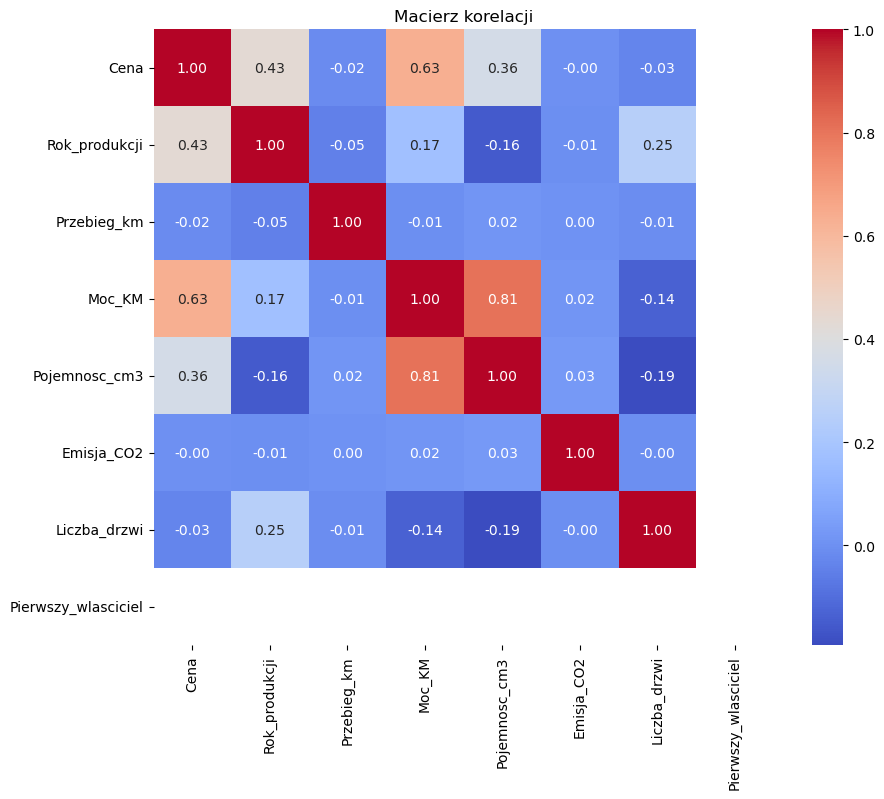

Cena                   1.000000
Moc_KM                 0.634104
Rok_produkcji          0.434695
Pojemnosc_cm3          0.357119
Emisja_CO2            -0.001078
Przebieg_km           -0.015136
Liczba_drzwi          -0.032287
Pierwszy_wlasciciel         NaN
Name: Cena, dtype: float64


In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Konwersja kolumny "Cena" na typ numeryczny, usuwając niepotrzebne znaki (np. spacje, złotówki)



# Wybór tylko kolumn numerycznych do obliczenia korelacji
numeric_columns = df_car_sales_train_data.select_dtypes(include=[np.number]).columns

# Obliczenie macierzy korelacji
correlation_matrix = df_car_sales_train_data[numeric_columns].corr()

# Wyświetlenie macierzy korelacji dla kolumny "Cena"
cena_correlation = correlation_matrix['Cena'].sort_values(ascending=False)

# Wizualizacja macierzy korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Macierz korelacji')
plt.show()

# Wyświetlenie korelacji z kolumną "Cena"
print(cena_correlation)

In [630]:
df_car_sales.drop(columns=["Emisja_CO2", "Data_publikacji_oferty", "Kolor"])


KeyError: 'Kraj'

In [33]:
bool_cols = df_car_sales.select_dtypes(include='bool').columns
df_car_sales[bool_cols] = df_car_sales[bool_cols].astype(float)

# df_car_sales.to_csv("Cleaned_test.csv", index=True)

Note:
- zastnanowić się czy wartości numerycznych nie zamienić na przedziały
- Uwzględnić nieproporcjonalność danych, rozważyć zastosowanie Oversamplingu


- Kiedy NIE usuwać wierszy?

    Gdy braki są systematyczne (np. wszystkie samochody marki "Opel" mają brakującą Emisja_CO2) – usuwanie wprowadzi bias.

    Gdy dane są rzadkie (np. tylko 100 wierszy), a usunięcie wierszy znacząco zmniejszy próbkę.

    Gdy można uzupełnić braki (np. średni Przebieg_km dla danej marki/roku).
